In [1]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "worldbank_data_exploration"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [2]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Dataset

In [3]:
from data_sources.load_dataset import load_time_series

time_series_dict, countries, years = load_time_series()

In [4]:
len(countries), countries[:10]

(93,
 array(['Albania', 'Angola', 'Australia', 'Austria', 'Azerbaijan',
        'Bangladesh', 'Belarus', 'Belgium', 'Bolivia', 'Brazil'],
       dtype=object))

In [5]:
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)

In [6]:
len(time_series_dict), time_series_dict.keys()

(15,
 dict_keys(['Access to electricity (% of population)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Exports of goods and services (% of GDP)', 'Fertility rate, total (births per woman)', 'Forest area (% of land area)', 'GDP growth (annual %)', 'Inflation, consumer prices (annual %)', 'Life expectancy at birth, total (years)', 'Merchandise trade (% of GDP)', 'Military expenditure (% of GDP)', 'Mortality rate, under-5 (per 1,000 live births)', 'Population growth (annual %)', 'Population in the largest city (% of urban population)', 'Total natural resources rents (% of GDP)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)']))

In [7]:
time_series_dict["Access to electricity (% of population)"].shape, time_series_dict[
    "Total natural resources rents (% of GDP)"
].shape

((93, 21), (93, 21))

In [8]:
X_all = np.vstack(list(time_series_dict.values()))
X_all.shape

(1395, 21)

# Utils

In [9]:
from sklearn.metrics import mean_absolute_error

In [10]:
def plot_history(
    history, title, ymax=None, print_mae=True, key="loss", figsize=(8, 5)
):
    plt.figure(figsize=figsize)

    plt.plot(np.arange(1, len(history[key]) + 1), history[key])

    plt.ylim(bottom=0)
    if ymax is not None:
        plt.ylim(top=ymax)

    plt.title(f"{title} ({min(history[key]):0.6f})")
    plt.grid()
    plt.show()


def plot_autoencoded(
    model,
    X,
    indices=[1, 100, 200, 300, 500, 650, 750, 900, 1000, 1127, 1394],
    rows=3,
    cols=4,
    figsize=(18, 11),
):
    plt.figure(figsize=figsize)

    X_enc = model.predict(X)

    normalizer = Normalizer()
    X_norm = normalizer.fit_transform(X)
    X_enc_norm = normalizer.transform(X_enc)

    mae_list = [
        mean_absolute_error(x, x_enc) * 10_000 for x, x_enc in zip(X_norm, X_enc_norm)
    ]
    indices = indices + [np.argmax(mae_list)]

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        plt.plot(years, X[idx], label="true")
        plt.plot(years, X_enc[idx], label="autoencoded")
        plt.title(f"{idx:3}, mae: {mae_list[idx]:0.6f}", fontsize=10)

    plt.legend()
    plt.show()

In [11]:
def train_features(n_bottleneck, autoencoder_all, all_path, train=False, n_epochs=8000, lr=None, lr_patience=200, verbose=0):
    for i, (feature, X) in enumerate(list(time_series_dict.items())):
        print(
            "==========================================================================================================================================="
        )
        print(f'({i + 1}) {feature}')
        print(
            "==========================================================================================================================================="
        )

        model_path = f"{pwd}/feature_extraction/model_weights/autoencoder_{n_bottleneck}/main_feature_set/{feature}"
        autoencoder = Autoencoder(n_bottleneck, input_len=INPUT_LEN, model_path=model_path)

        if train:
            autoencoder.load_weights(path=all_path)
            autoencoder.compile_and_train(X, n_epochs=n_epochs, lr=lr, verbose=verbose, lr_patience=lr_patience)

        autoencoder.load_weights()

        print(
            f"Loss: {autoencoder.compile_and_evaluate(X):0.6f}. Before fine-tuning: {autoencoder_all.compile_and_evaluate(X):0.6f}"
        )
        
def eval_features(n_bottleneck, autoencoder_all, show_lr=False, indices=[1, 21, 37], ymax=40):
    for feature, X in list(time_series_dict.items()):
        print(
            "==========================================================================================================================================="
        )
        print(feature)
        print(
            "==========================================================================================================================================="
        )

        model_path = f"{pwd}/feature_extraction/model_weights/autoencoder_{n_bottleneck}/main_feature_set/{feature}"
        autoencoder = Autoencoder(
            n_bottleneck, input_len=INPUT_LEN, model_path=model_path
        ).load_weights()

        print(
            f"Loss: {autoencoder.compile_and_evaluate(X):0.6f}. Before fine-tuning: {autoencoder_all.compile_and_evaluate(X):0.6f}"
        )

        plot_history(autoencoder.history, feature, ymax=ymax)
        if show_lr:
            plot_history(autoencoder.history, 'Learning rate', key='lr', print_mae=False, figsize=(6, 4))
        plot_autoencoded(
            autoencoder, X, indices=indices, rows=1, cols=4, figsize=(18, 4)
        )

# Train (n_bottleneck=2)

## Train on all time series types

In [12]:
from feature_extraction.utils import Normalizer
from feature_extraction import Autoencoder

N_BOTTLENECK = 2
INPUT_LEN = 21
ALL_PATH = f"{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/main_feature_set/all"

In [13]:
autoencoder_all = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, model_path=ALL_PATH)

# autoencoder_all.compile_and_train(X_all, n_epochs=10_000, verbose=2, lr=0.001, lr_patience=200)

autoencoder_all.load_weights()

print(f"Loss: {autoencoder_all.compile_and_evaluate(X_all):0.6f}")

44/44 [==============================] - 2s 4ms/step - loss: 65.3863
Loss: 65.386269


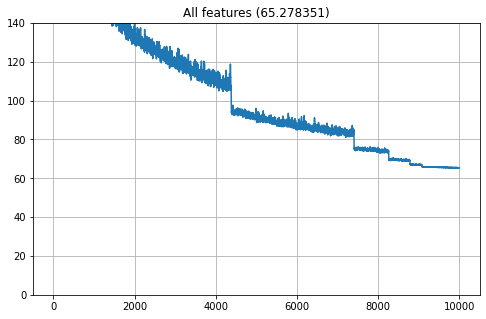

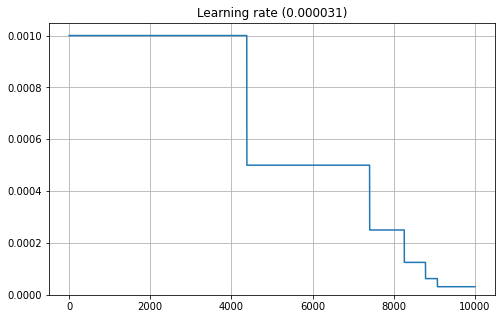

In [14]:
plot_history(autoencoder_all.history, "All features", ymax=140)
plot_history(autoencoder_all.history, "Learning rate", key="lr", print_mae=False)

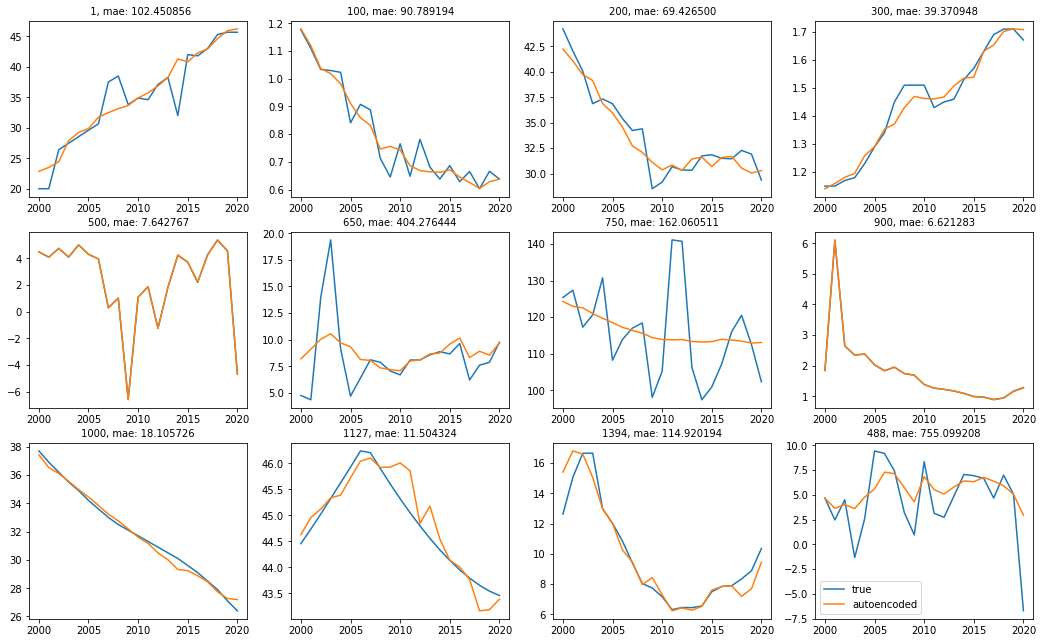

In [15]:
plot_autoencoded(autoencoder_all, X_all)

##  Fine-tune for each time series type

In [16]:
train_features(N_BOTTLENECK, autoencoder_all, ALL_PATH, train=False, lr=0.0002)

(1) Access to electricity (% of population)
3/3 [==============================] - 0s 3ms/step - loss: 14.1177
Loss: 5.166488. Before fine-tuning: 14.117740
(2) Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 82.5574
Loss: 22.430126. Before fine-tuning: 82.557426
(3) Exports of goods and services (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 77.5252
Loss: 13.704553. Before fine-tuning: 77.525162
(4) Fertility rate, total (births per woman)
3/3 [==============================] - 0s 3ms/step - loss: 29.1938
Loss: 8.207604. Before fine-tuning: 29.193827
(5) Forest area (% of land area)
3/3 [==============================] - 0s 4ms/step - loss: 7.4147
Loss: 2.548264. Before fine-tuning: 7.414701
(6) GDP growth (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 139.6155
Loss: 17.470512. Before fine-tuning: 139.615463
(7) Inflation, consumer prices (annual %)
3/3 [================

Access to electricity (% of population)
3/3 [==============================] - 0s 4ms/step - loss: 14.1177
Loss: 5.166488. Before fine-tuning: 14.117740


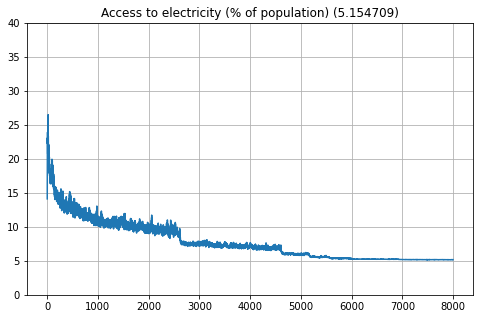

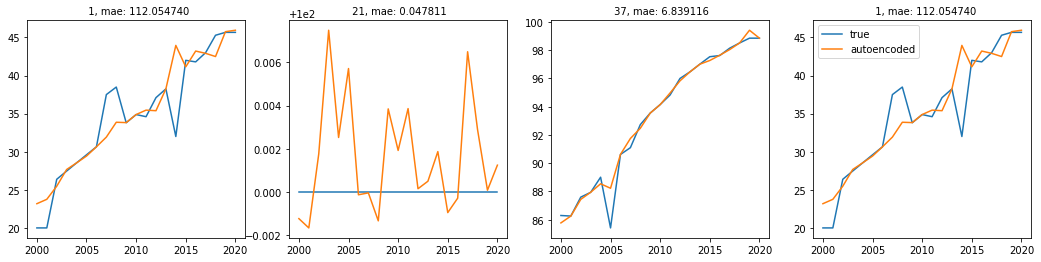

Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 3ms/step - loss: 82.5574
Loss: 22.430126. Before fine-tuning: 82.557426


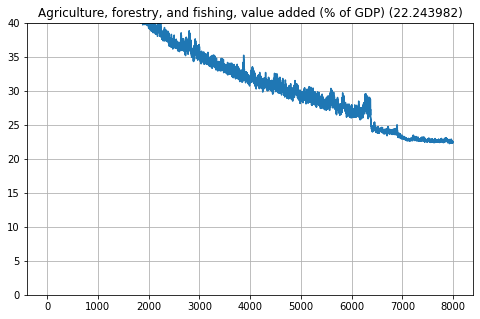

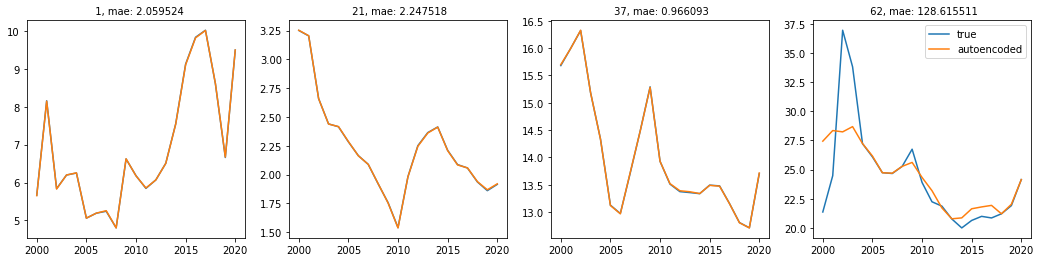

Exports of goods and services (% of GDP)
3/3 [==============================] - 0s 5ms/step - loss: 77.5252
Loss: 13.704553. Before fine-tuning: 77.525162


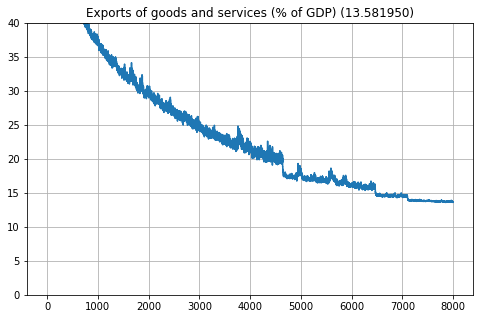

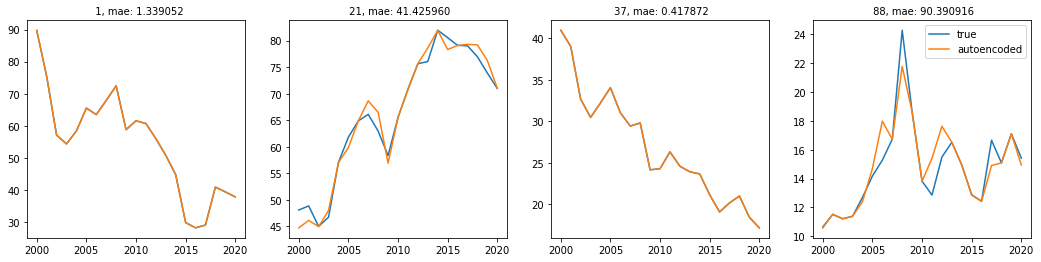

Fertility rate, total (births per woman)
3/3 [==============================] - 0s 5ms/step - loss: 29.1938
Loss: 8.207604. Before fine-tuning: 29.193827


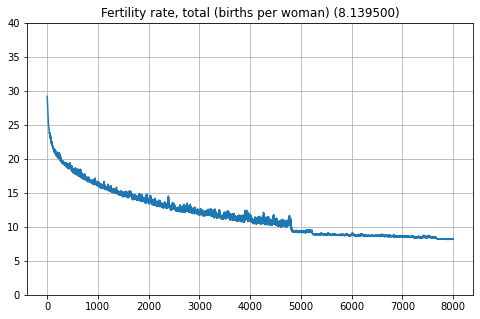

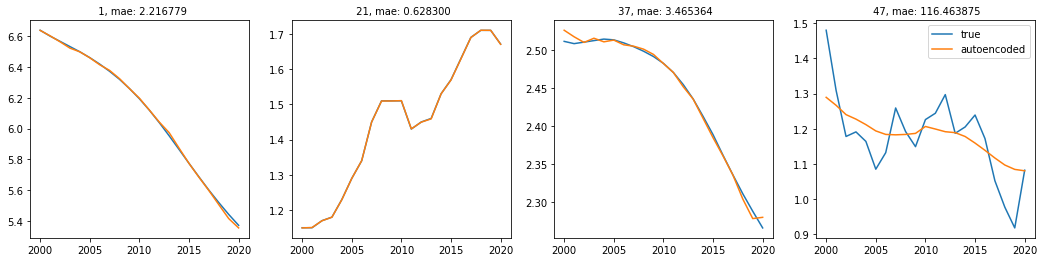

Forest area (% of land area)
3/3 [==============================] - 0s 4ms/step - loss: 7.4147
Loss: 2.548264. Before fine-tuning: 7.414701


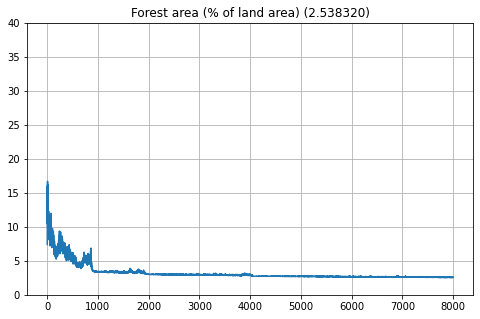

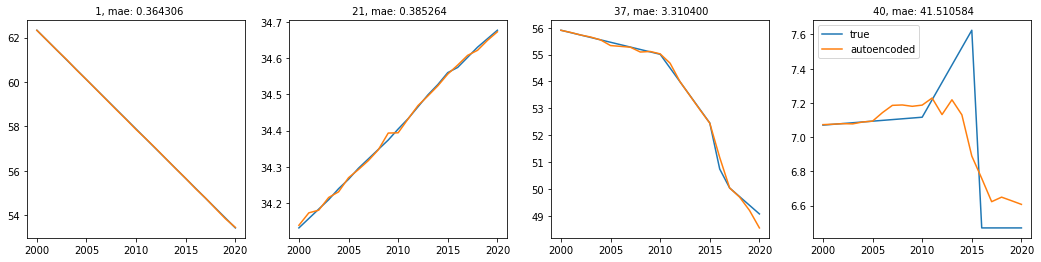

GDP growth (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 139.6155
Loss: 17.470512. Before fine-tuning: 139.615463


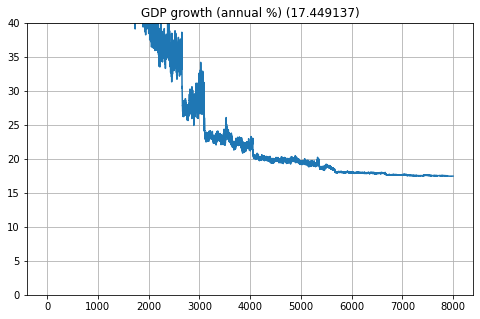

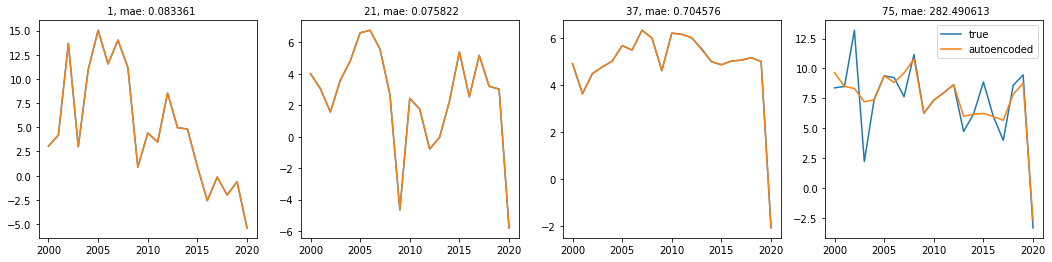

Inflation, consumer prices (annual %)
3/3 [==============================] - 0s 5ms/step - loss: 128.4365
Loss: 18.602543. Before fine-tuning: 128.436493


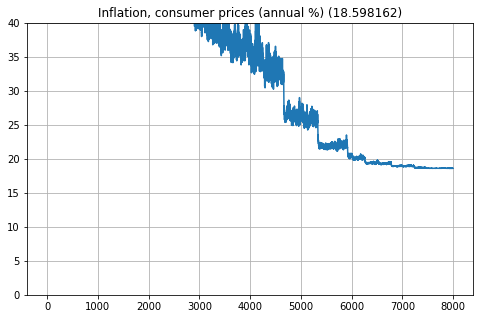

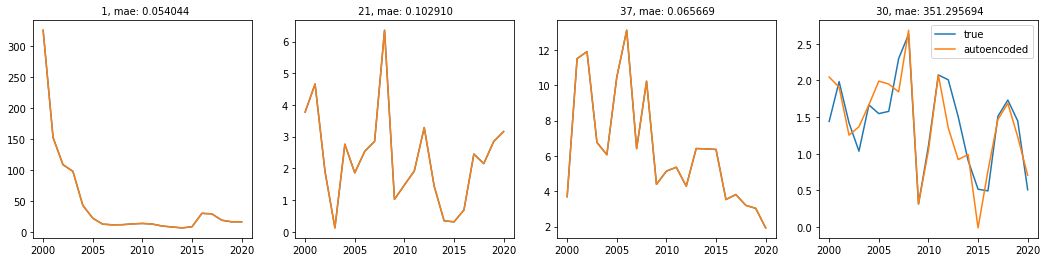

Life expectancy at birth, total (years)
3/3 [==============================] - 0s 4ms/step - loss: 4.5383
Loss: 2.630964. Before fine-tuning: 4.538315


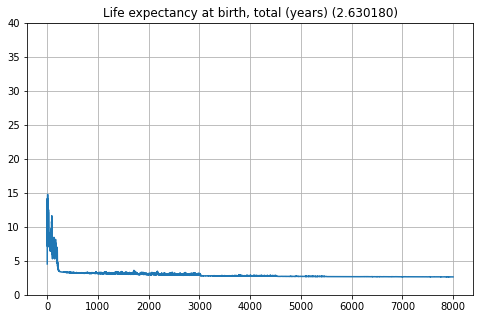

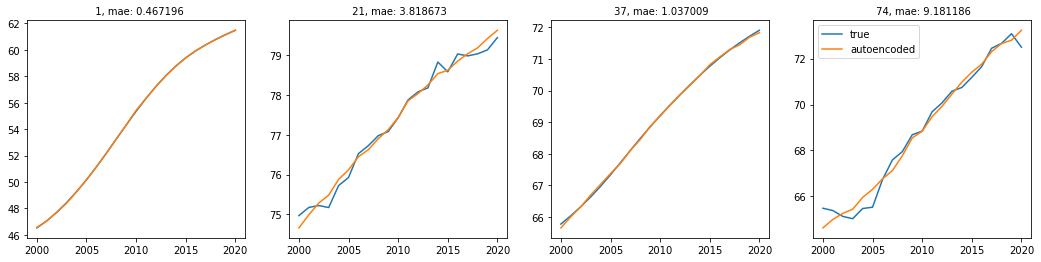

Merchandise trade (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 83.7120
Loss: 13.808054. Before fine-tuning: 83.711967


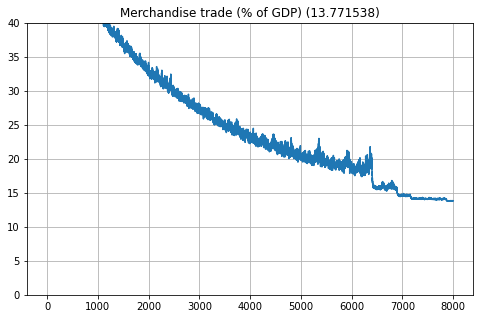

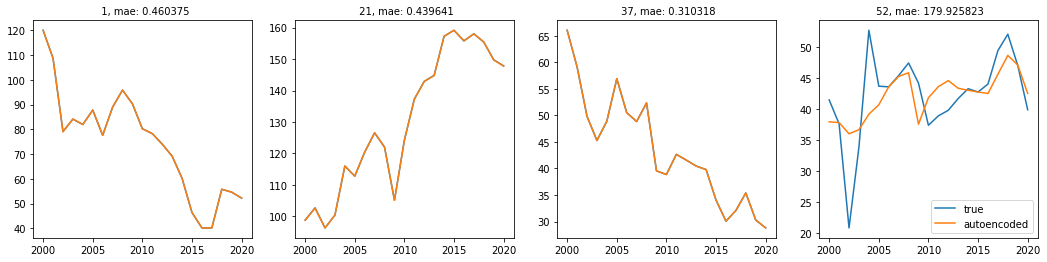

Military expenditure (% of GDP)
3/3 [==============================] - 0s 5ms/step - loss: 93.8628
Loss: 20.714077. Before fine-tuning: 93.862770


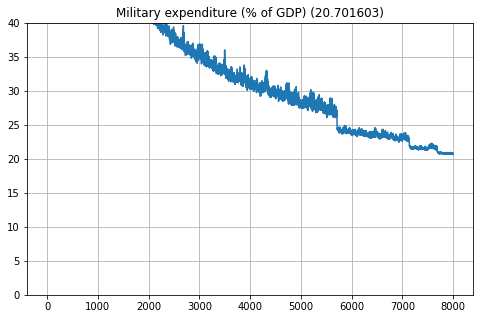

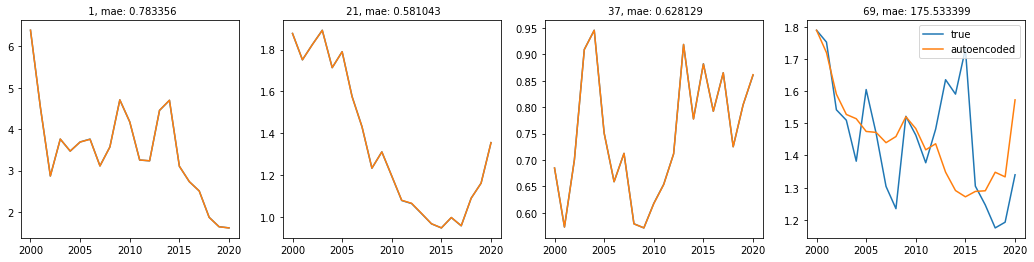

Mortality rate, under-5 (per 1,000 live births)
3/3 [==============================] - 0s 4ms/step - loss: 25.9371
Loss: 10.631475. Before fine-tuning: 25.937061


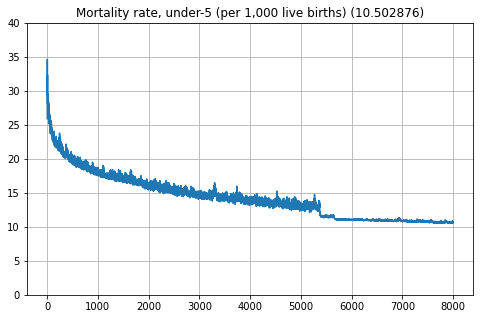

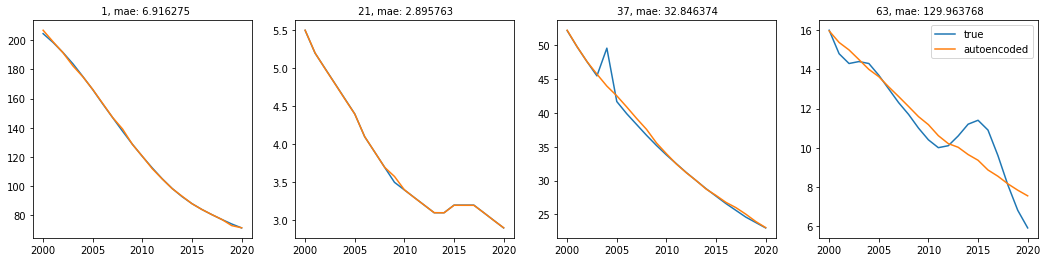

Population growth (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 61.2872
Loss: 4.696459. Before fine-tuning: 61.287151


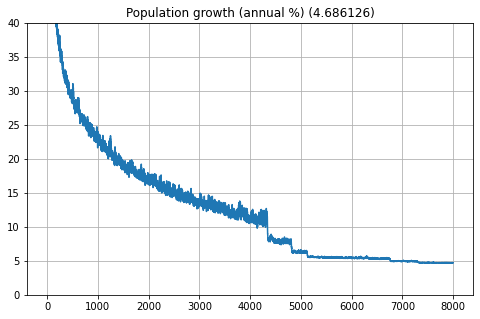

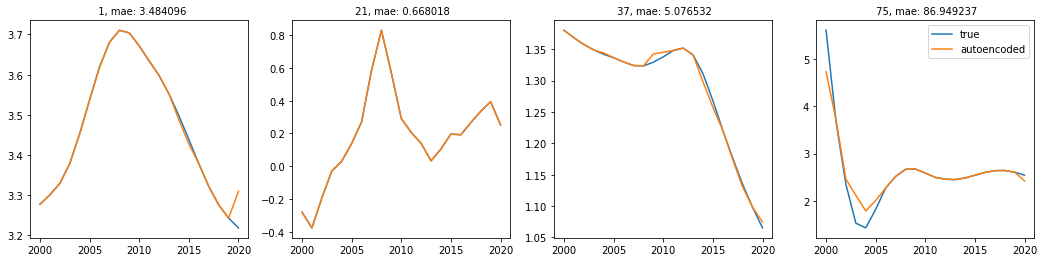

Population in the largest city (% of urban population)
3/3 [==============================] - 0s 4ms/step - loss: 10.0515
Loss: 5.140114. Before fine-tuning: 10.051519


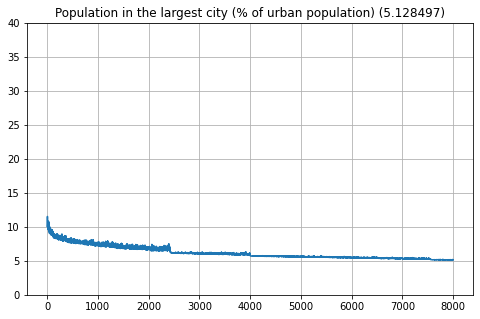

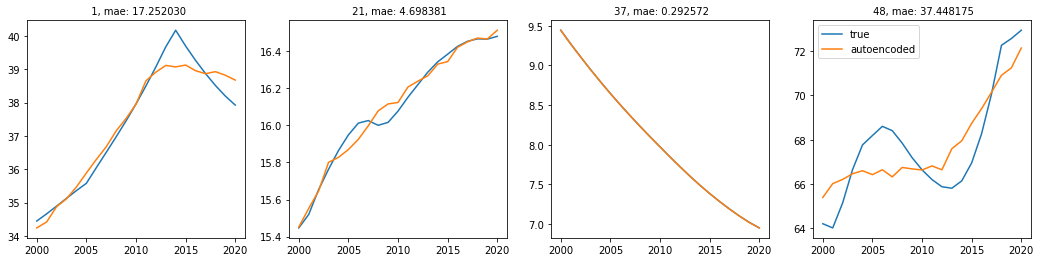

Total natural resources rents (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 116.9197
Loss: 22.050634. Before fine-tuning: 116.919670


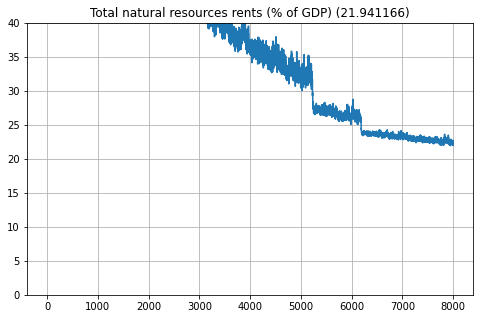

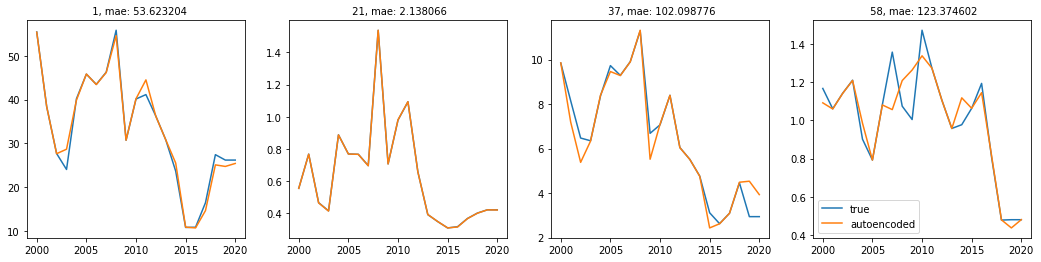

Unemployment, total (% of total labor force) (modeled ILO estimate)
3/3 [==============================] - 0s 4ms/step - loss: 105.6249
Loss: 18.702269. Before fine-tuning: 105.624893


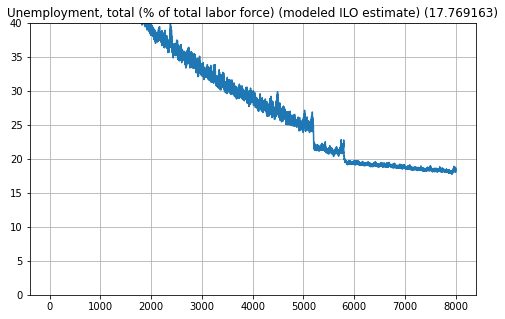

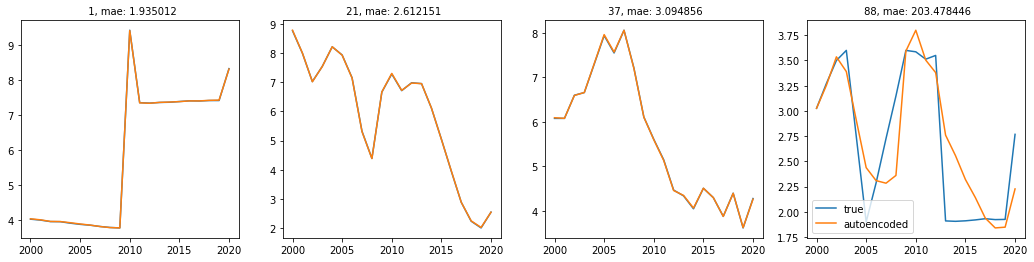

In [17]:
eval_features(N_BOTTLENECK, autoencoder_all, ymax=40, show_lr=False)

# Train (n_bottleneck=4)

## Train on all time series types

In [18]:
N_BOTTLENECK = 4
INPUT_LEN = 21
ALL_PATH = f"{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/main_feature_set/all"

In [19]:
autoencoder_all = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, model_path=ALL_PATH)

# autoencoder_all.compile_and_train(X_all, n_epochs=10_000, verbose=2, lr=0.001, lr_patience=200)

autoencoder_all.load_weights()

print(f"Loss: {autoencoder_all.compile_and_evaluate(X_all):0.6f}")

44/44 [==============================] - 0s 3ms/step - loss: 18.5166
Loss: 18.516617


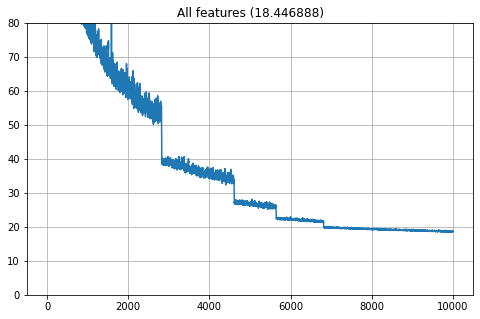

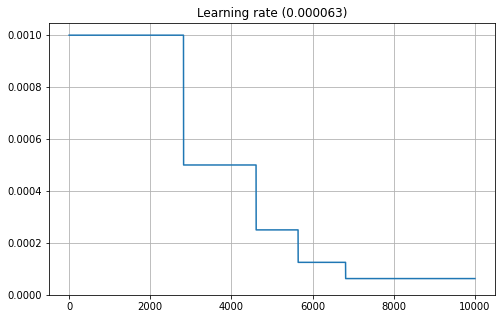

In [20]:
plot_history(autoencoder_all.history, "All features", ymax=80)
plot_history(autoencoder_all.history, "Learning rate", key="lr", print_mae=False)

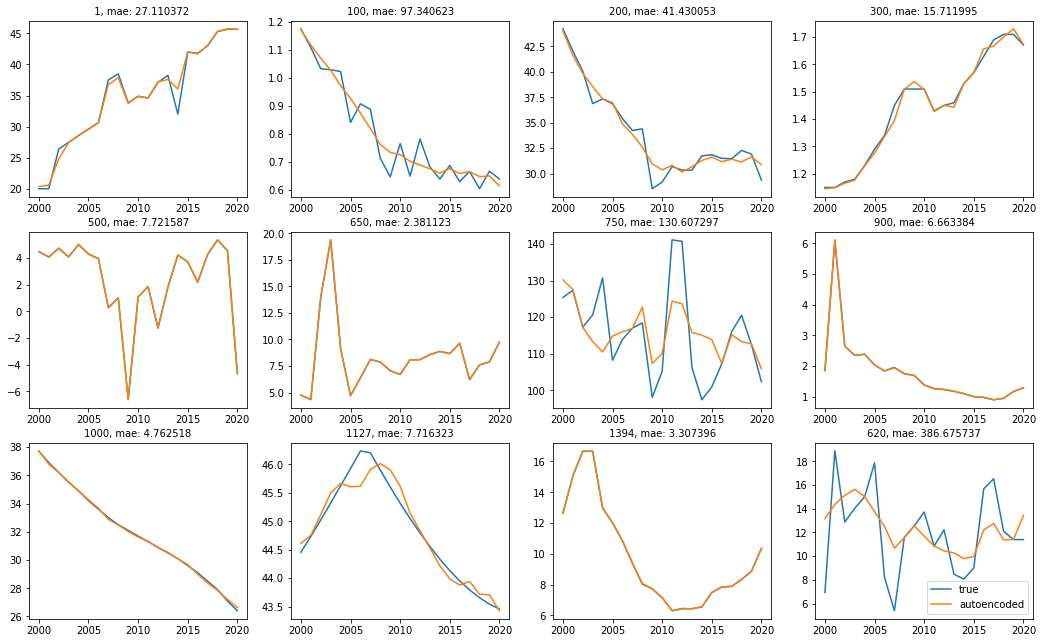

In [21]:
plot_autoencoded(autoencoder_all, X_all)

## Fine-tune for each time series type

In [22]:
train_features(N_BOTTLENECK, autoencoder_all, ALL_PATH, train=False, lr=0.0002)

(1) Access to electricity (% of population)
3/3 [==============================] - 0s 4ms/step - loss: 9.5924
Loss: 4.387406. Before fine-tuning: 9.592366
(2) Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 43.7736
Loss: 6.309329. Before fine-tuning: 43.773586
(3) Exports of goods and services (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 30.7627
Loss: 3.905946. Before fine-tuning: 30.762669
(4) Fertility rate, total (births per woman)
3/3 [==============================] - 0s 4ms/step - loss: 15.9352
Loss: 3.478080. Before fine-tuning: 15.935213
(5) Forest area (% of land area)
3/3 [==============================] - 0s 5ms/step - loss: 3.7092
Loss: 1.129421. Before fine-tuning: 3.709175
(6) GDP growth (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 8.1604
Loss: 0.000430. Before fine-tuning: 8.160371
(7) Inflation, consumer prices (annual %)
3/3 [=========================

Access to electricity (% of population)
3/3 [==============================] - 0s 4ms/step - loss: 9.5924
Loss: 4.387406. Before fine-tuning: 9.592366


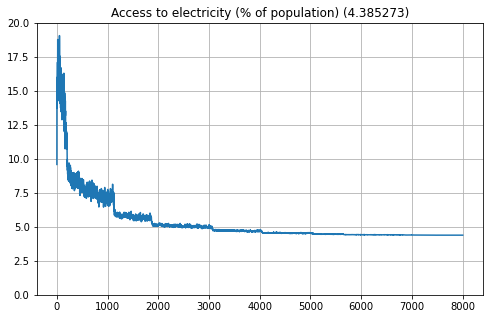

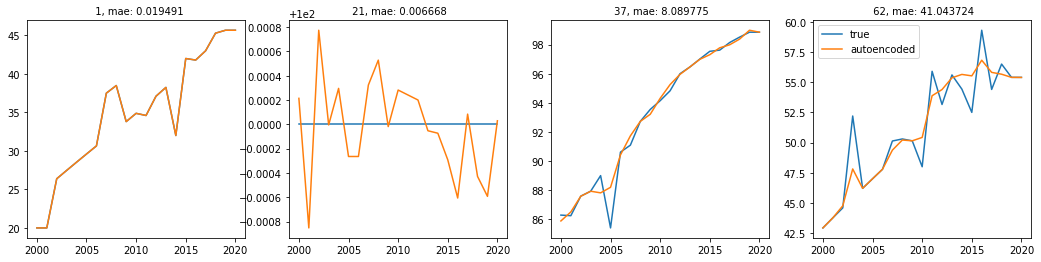

Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 5ms/step - loss: 43.7736
Loss: 6.309329. Before fine-tuning: 43.773586


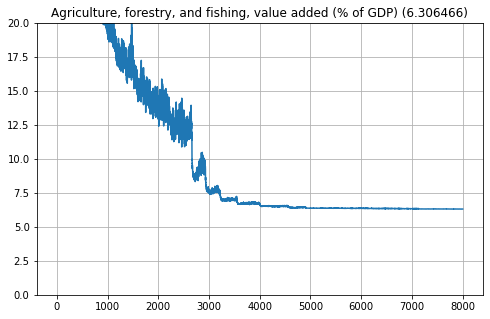

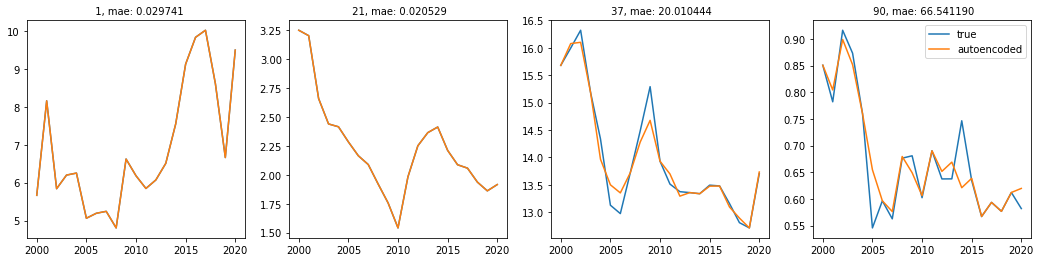

Exports of goods and services (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 30.7627
Loss: 3.905946. Before fine-tuning: 30.762669


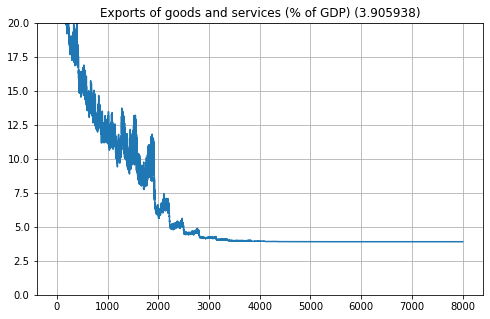

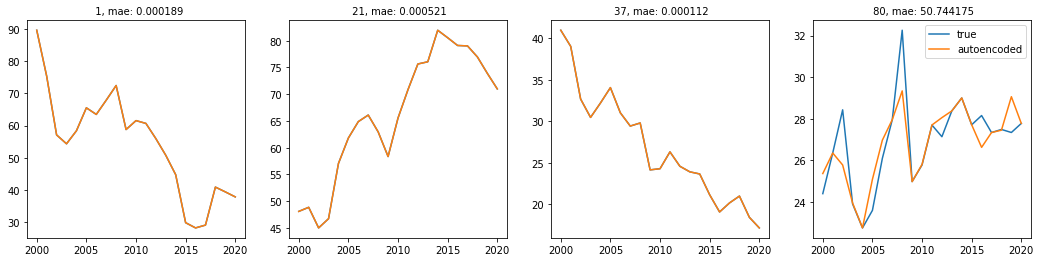

Fertility rate, total (births per woman)
3/3 [==============================] - 0s 4ms/step - loss: 15.9352
Loss: 3.478080. Before fine-tuning: 15.935213


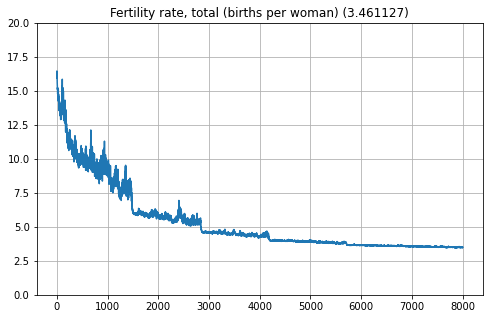

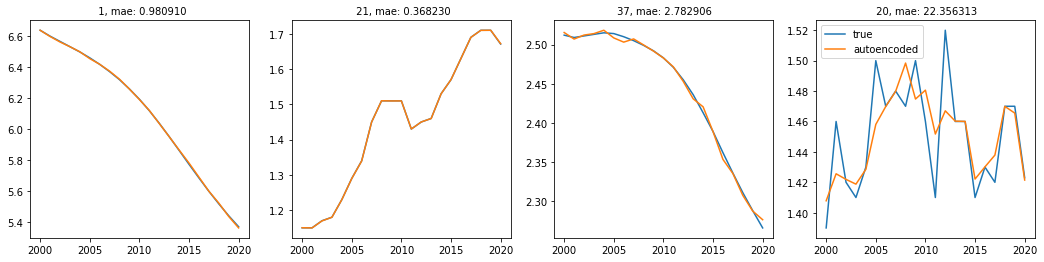

Forest area (% of land area)
3/3 [==============================] - 0s 4ms/step - loss: 3.7092
Loss: 1.129421. Before fine-tuning: 3.709175


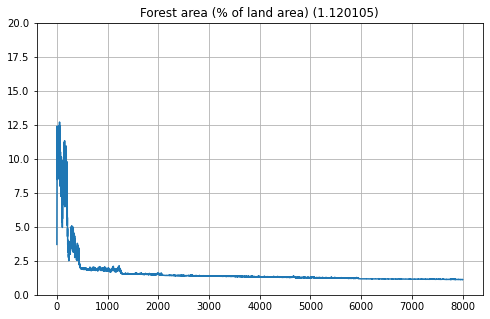

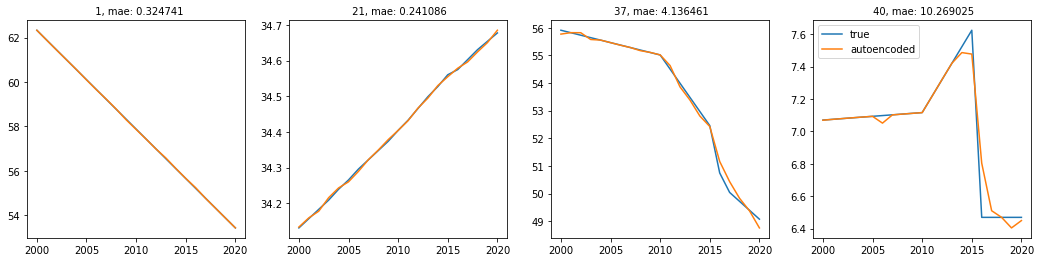

GDP growth (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 8.1604
Loss: 0.000430. Before fine-tuning: 8.160371


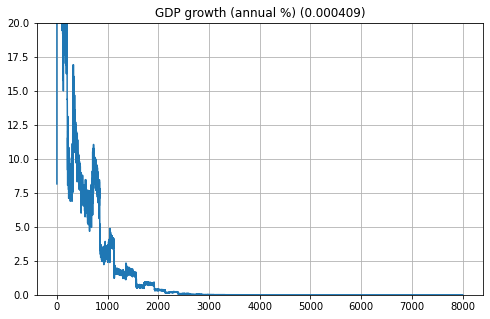

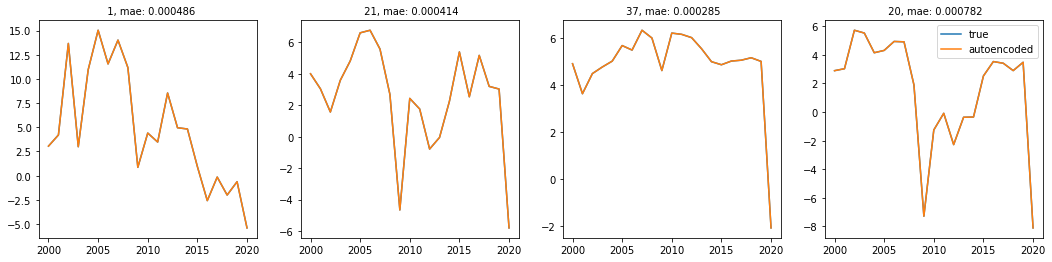

Inflation, consumer prices (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 17.0162
Loss: 1.224425. Before fine-tuning: 17.016230


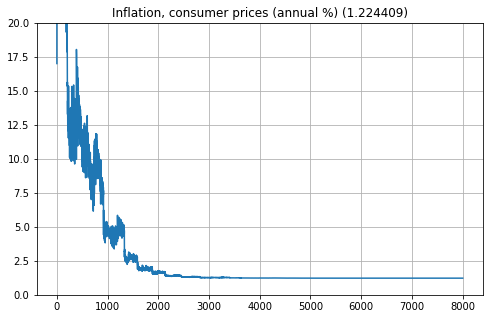

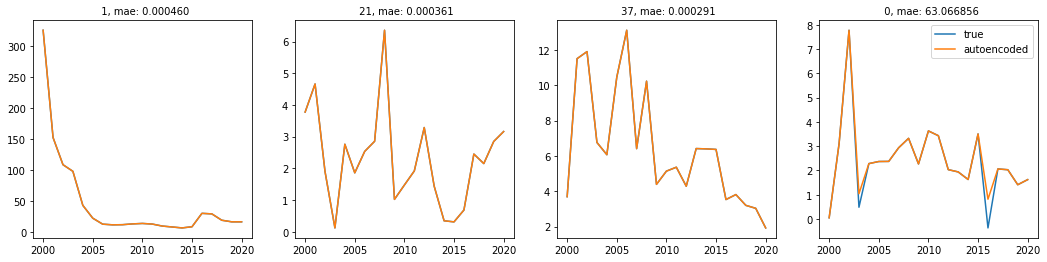

Life expectancy at birth, total (years)
3/3 [==============================] - 0s 4ms/step - loss: 3.0161
Loss: 1.669152. Before fine-tuning: 3.016140


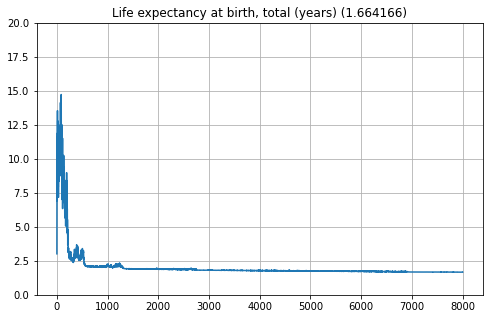

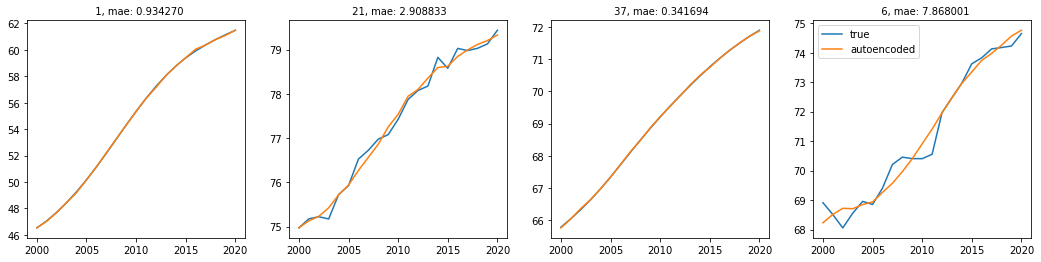

Merchandise trade (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 33.5433
Loss: 5.530453. Before fine-tuning: 33.543262


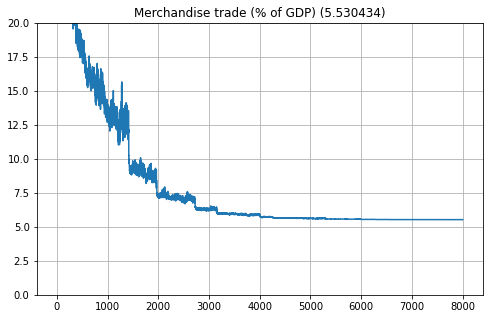

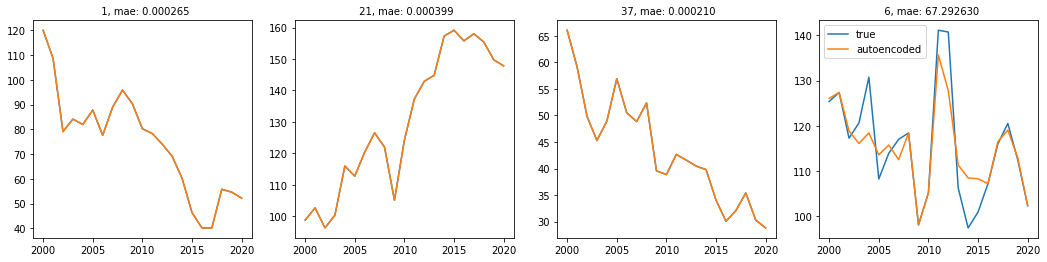

Military expenditure (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 38.2224
Loss: 4.867450. Before fine-tuning: 38.222404


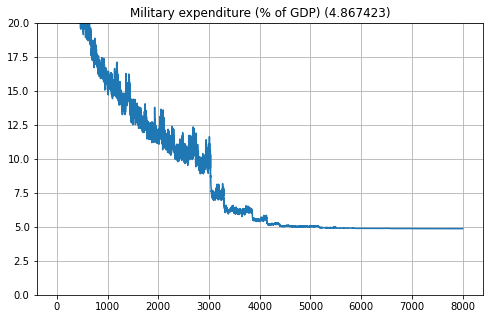

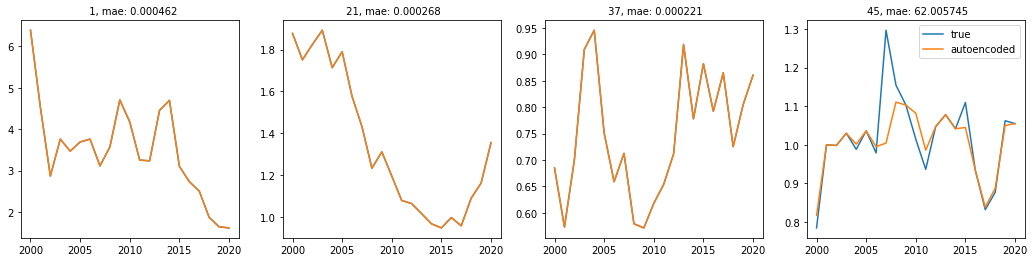

Mortality rate, under-5 (per 1,000 live births)
3/3 [==============================] - 0s 5ms/step - loss: 12.2552
Loss: 3.533759. Before fine-tuning: 12.255235


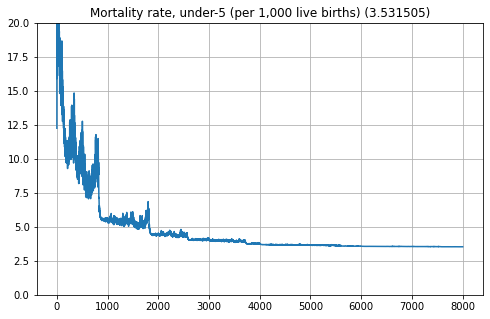

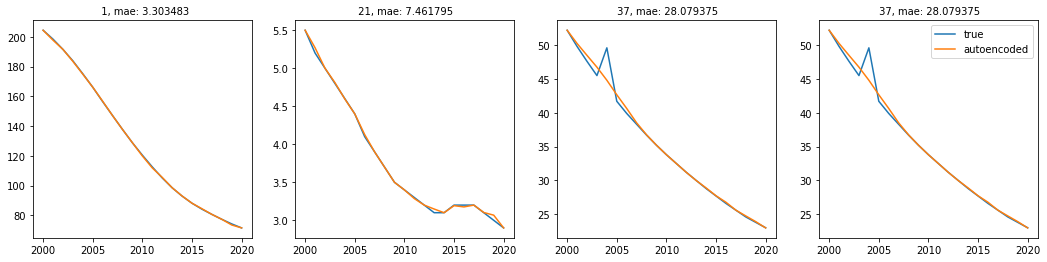

Population growth (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 14.2542
Loss: 0.409236. Before fine-tuning: 14.254154


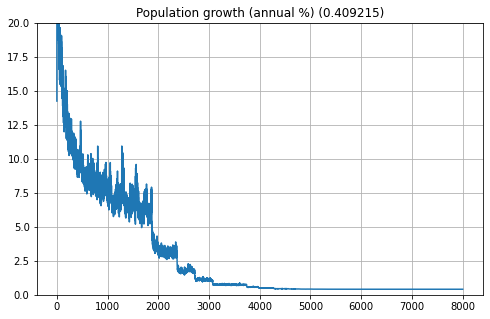

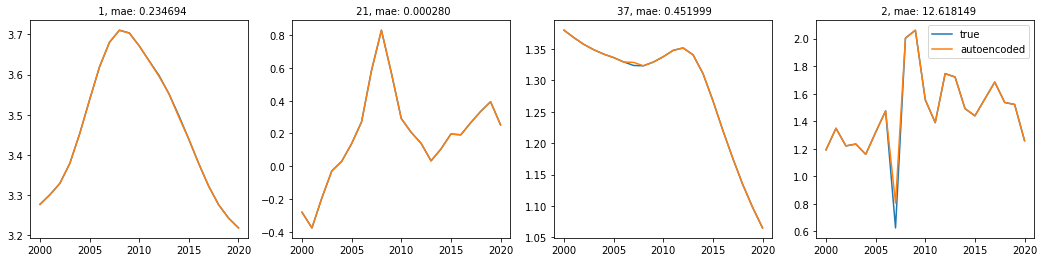

Population in the largest city (% of urban population)
3/3 [==============================] - 0s 4ms/step - loss: 5.2392
Loss: 2.153075. Before fine-tuning: 5.239188


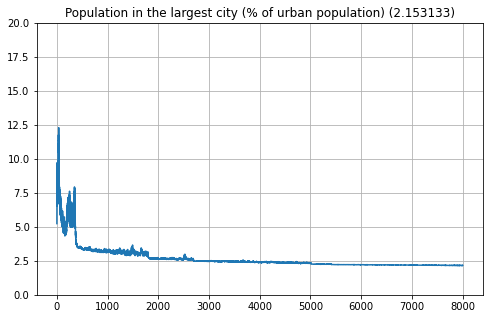

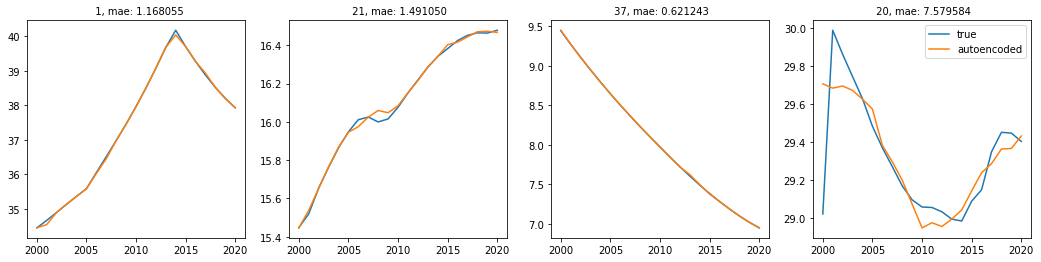

Total natural resources rents (% of GDP)
3/3 [==============================] - 0s 5ms/step - loss: 16.4154
Loss: 0.813696. Before fine-tuning: 16.415405


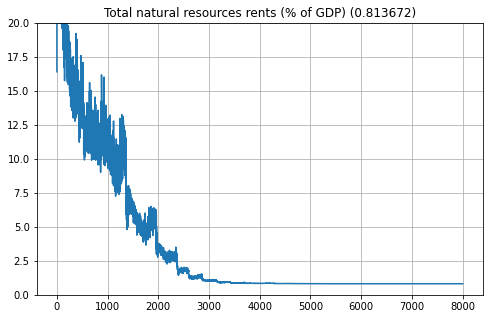

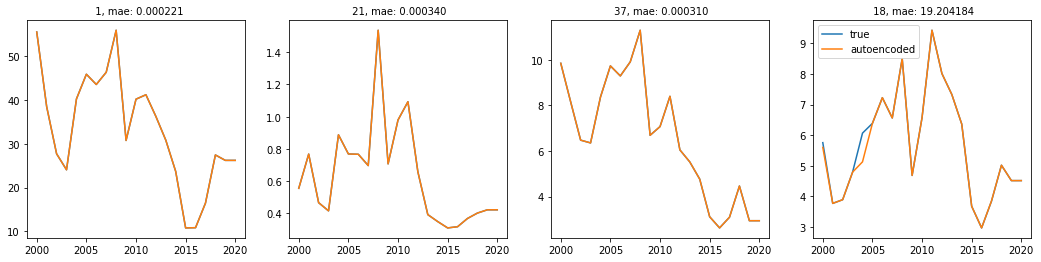

Unemployment, total (% of total labor force) (modeled ILO estimate)
3/3 [==============================] - 0s 3ms/step - loss: 25.8539
Loss: 1.686761. Before fine-tuning: 25.853870


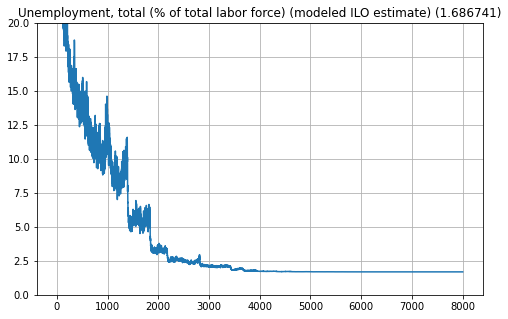

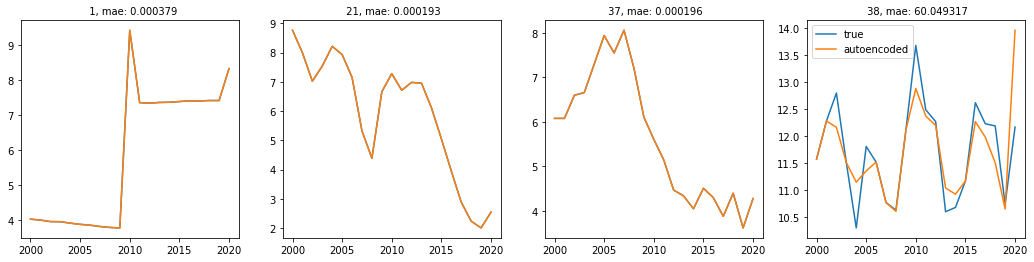

In [23]:
eval_features(N_BOTTLENECK, autoencoder_all, ymax=20, show_lr=False)

# Train (n_bottleneck=8)

## Train on all time series types

In [24]:
N_BOTTLENECK = 8
INPUT_LEN = 21
ALL_PATH = f"{pwd}/feature_extraction/model_weights/autoencoder_{N_BOTTLENECK}/main_feature_set/all"

In [25]:
autoencoder_all = Autoencoder(N_BOTTLENECK, input_len=INPUT_LEN, model_path=ALL_PATH)

# autoencoder_all.compile_and_train(X_all, n_epochs=10_000, verbose=2, lr=0.001, lr_patience=200)

autoencoder_all.load_weights()

print(f"Loss: {autoencoder_all.compile_and_evaluate(X_all):0.6f}")

44/44 [==============================] - 0s 4ms/step - loss: 6.1625
Loss: 6.162504


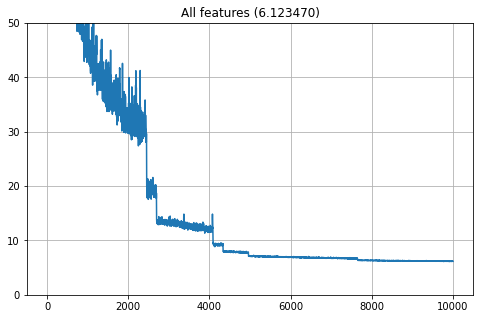

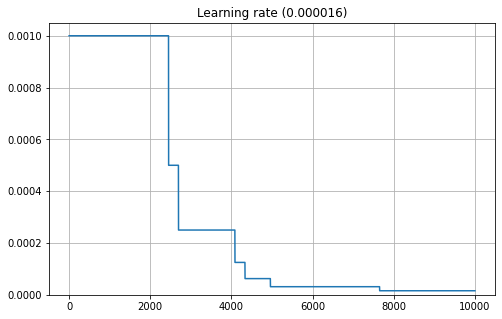

In [26]:
plot_history(autoencoder_all.history, "All features", ymax=50)
plot_history(autoencoder_all.history, "Learning rate", key="lr", print_mae=False)

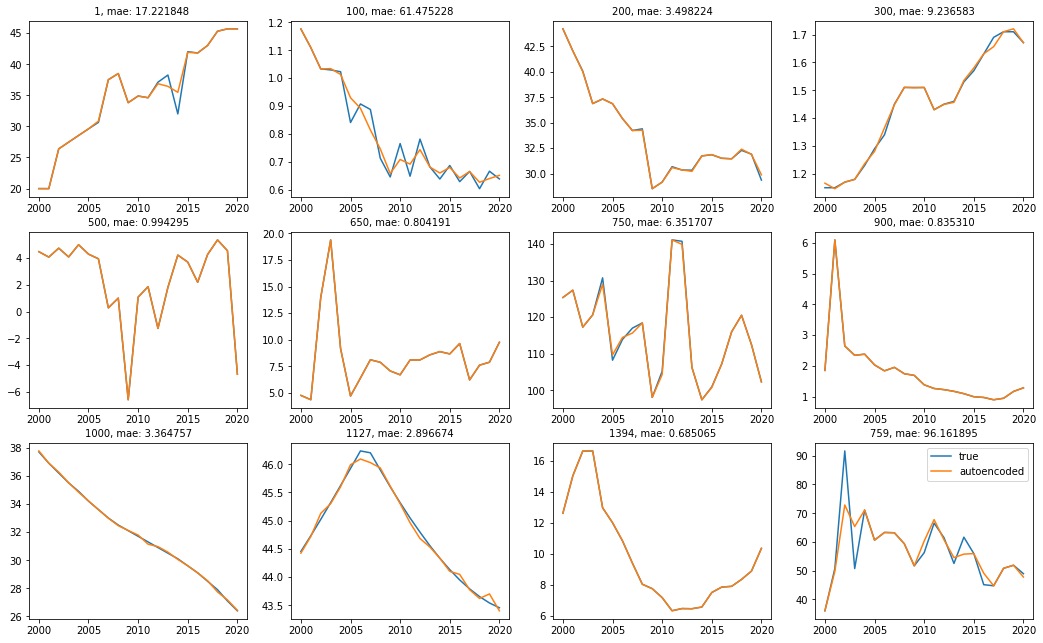

In [27]:
plot_autoencoded(autoencoder_all, X_all)

## Fine-tune for each time series type

In [28]:
train_features(N_BOTTLENECK, autoencoder_all, ALL_PATH, train=False, lr=0.0002)

(1) Access to electricity (% of population)
3/3 [==============================] - 0s 3ms/step - loss: 6.4521
Loss: 2.534847. Before fine-tuning: 6.452058
(2) Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 5ms/step - loss: 18.1282
Loss: 0.879083. Before fine-tuning: 18.128218
(3) Exports of goods and services (% of GDP)
3/3 [==============================] - 0s 3ms/step - loss: 9.5078
Loss: 0.459244. Before fine-tuning: 9.507801
(4) Fertility rate, total (births per woman)
3/3 [==============================] - 0s 4ms/step - loss: 7.6229
Loss: 1.326239. Before fine-tuning: 7.622937
(5) Forest area (% of land area)
3/3 [==============================] - 0s 5ms/step - loss: 2.1640
Loss: 0.593562. Before fine-tuning: 2.163971
(6) GDP growth (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 1.1634
Loss: 0.000282. Before fine-tuning: 1.163411
(7) Inflation, consumer prices (annual %)
3/3 [=============================

Access to electricity (% of population)
3/3 [==============================] - 0s 3ms/step - loss: 6.4521
Loss: 2.534847. Before fine-tuning: 6.452058


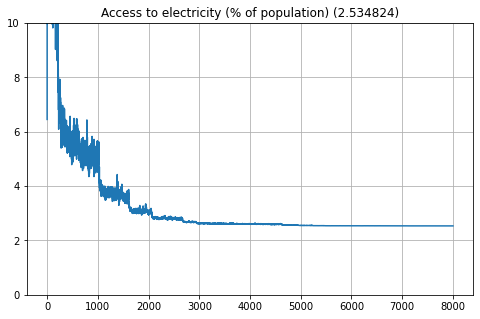

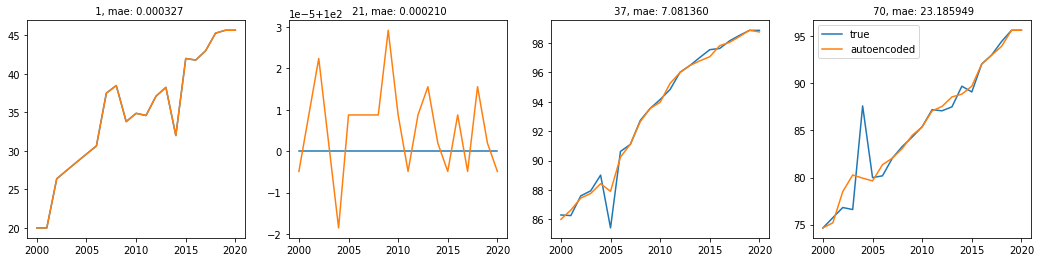

Agriculture, forestry, and fishing, value added (% of GDP)
3/3 [==============================] - 0s 18ms/step - loss: 18.1282
Loss: 0.879083. Before fine-tuning: 18.128218


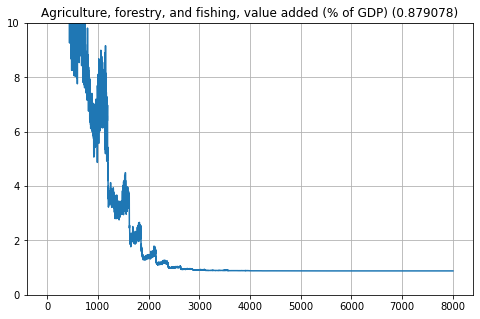

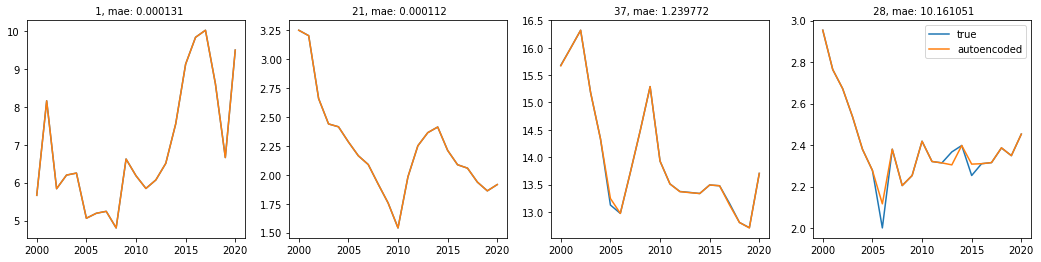

Exports of goods and services (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 9.5078
Loss: 0.459244. Before fine-tuning: 9.507801


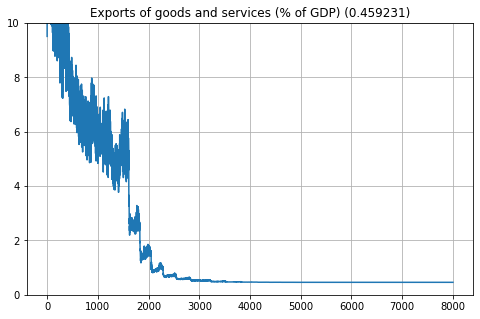

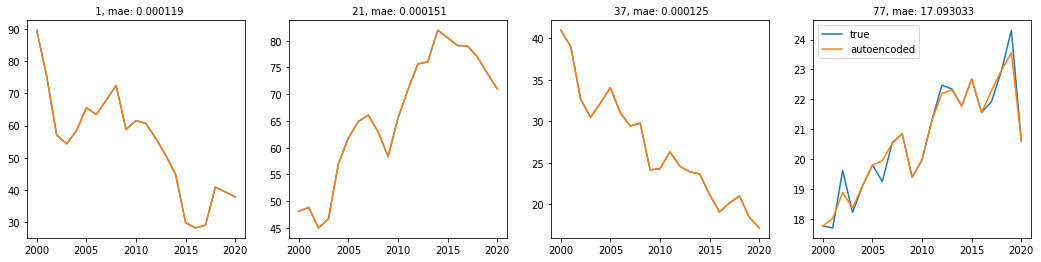

Fertility rate, total (births per woman)
3/3 [==============================] - 0s 5ms/step - loss: 7.6229
Loss: 1.326239. Before fine-tuning: 7.622937


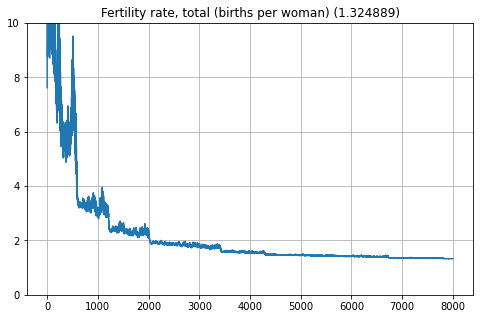

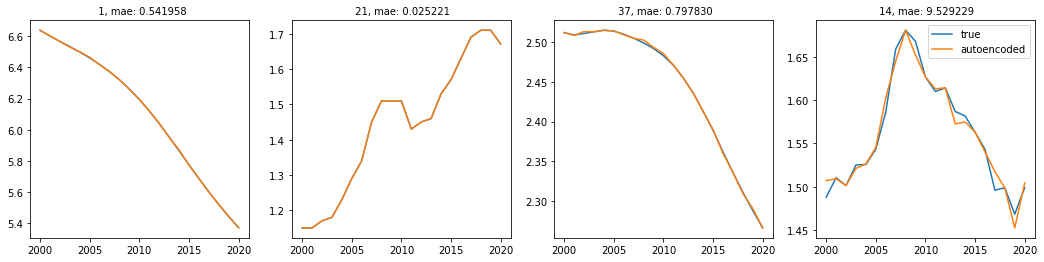

Forest area (% of land area)
3/3 [==============================] - 0s 3ms/step - loss: 2.1640
Loss: 0.593562. Before fine-tuning: 2.163971


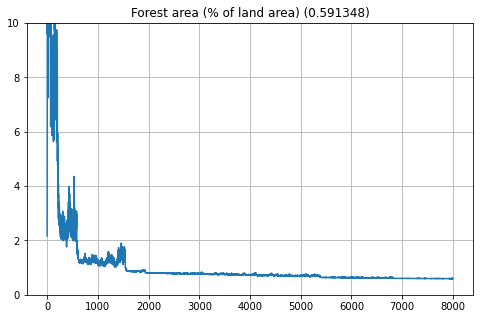

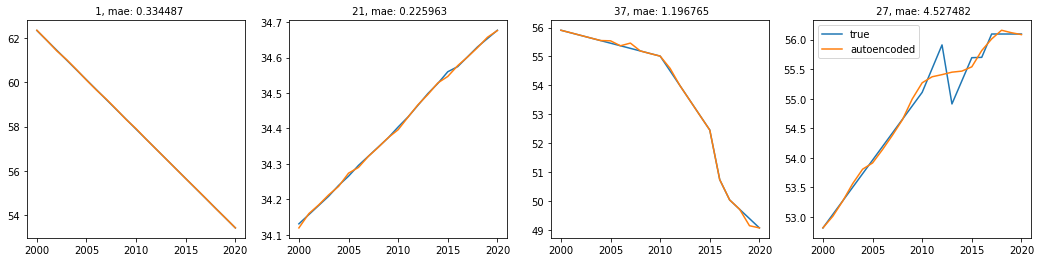

GDP growth (annual %)
3/3 [==============================] - 0s 3ms/step - loss: 1.1634
Loss: 0.000282. Before fine-tuning: 1.163411


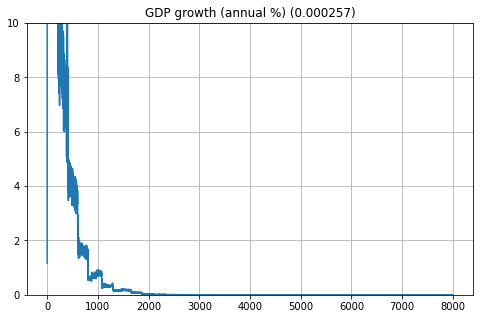

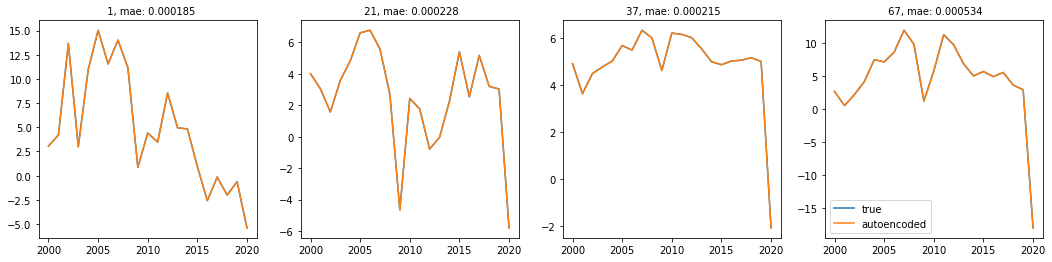

Inflation, consumer prices (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 1.4039
Loss: 0.000236. Before fine-tuning: 1.403864


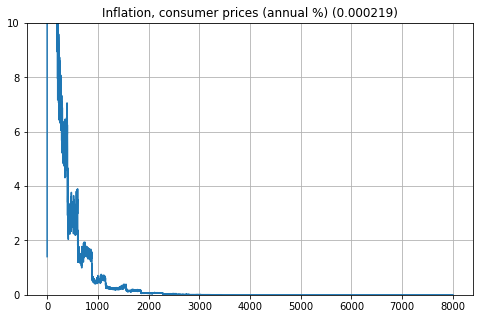

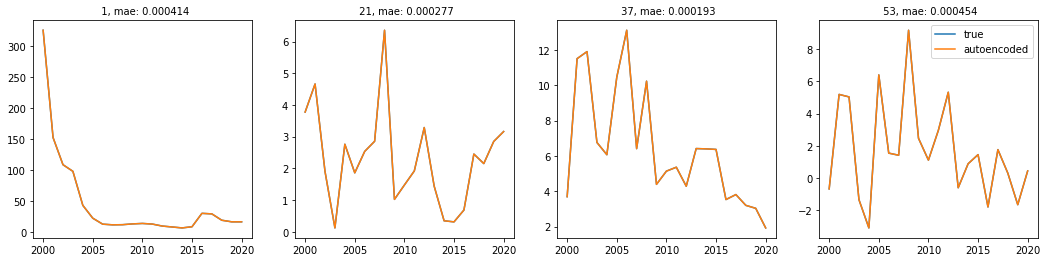

Life expectancy at birth, total (years)
3/3 [==============================] - 0s 3ms/step - loss: 1.9360
Loss: 1.108784. Before fine-tuning: 1.935986


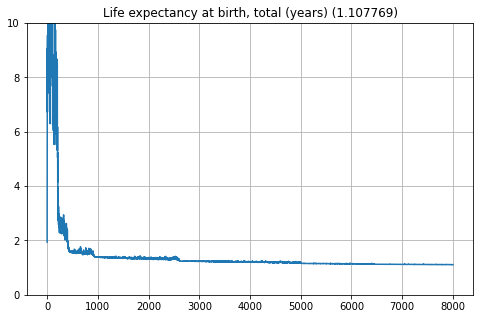

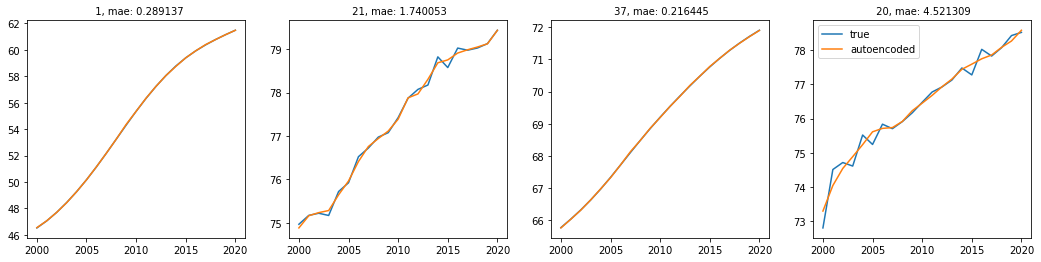

Merchandise trade (% of GDP)
3/3 [==============================] - 0s 3ms/step - loss: 13.6086
Loss: 0.674037. Before fine-tuning: 13.608583


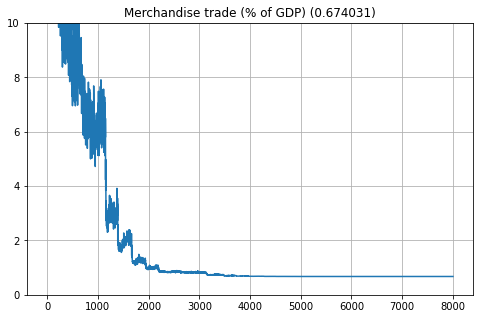

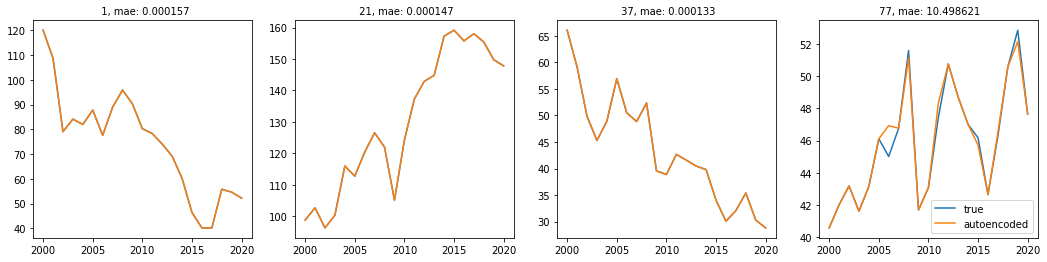

Military expenditure (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 11.4361
Loss: 0.829519. Before fine-tuning: 11.436089


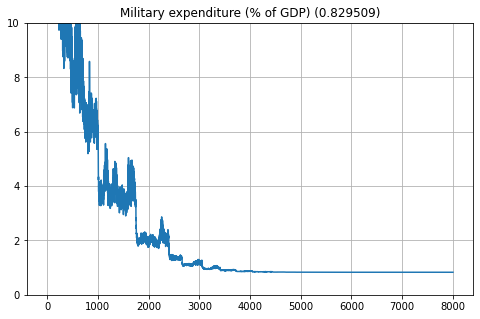

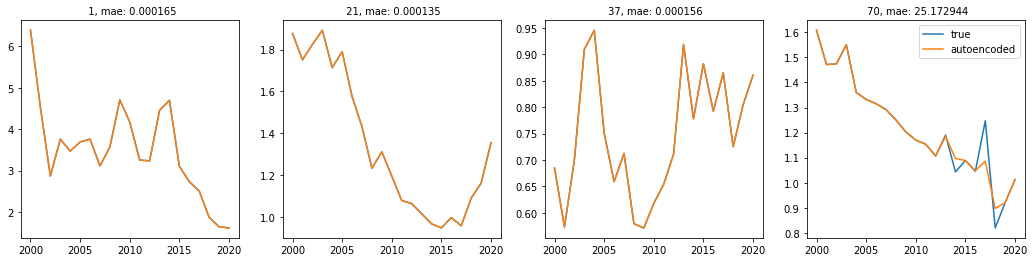

Mortality rate, under-5 (per 1,000 live births)
3/3 [==============================] - 0s 4ms/step - loss: 6.1036
Loss: 2.142116. Before fine-tuning: 6.103636


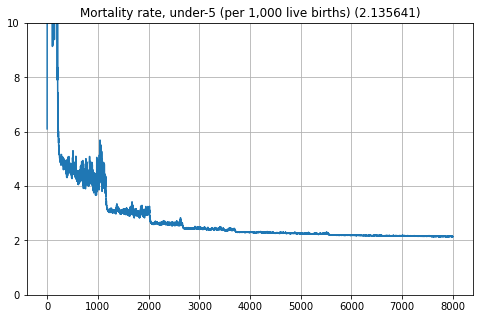

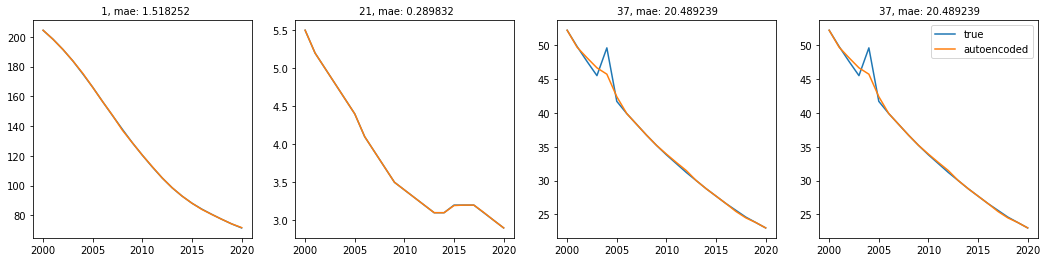

Population growth (annual %)
3/3 [==============================] - 0s 4ms/step - loss: 3.2790
Loss: 0.238362. Before fine-tuning: 3.279020


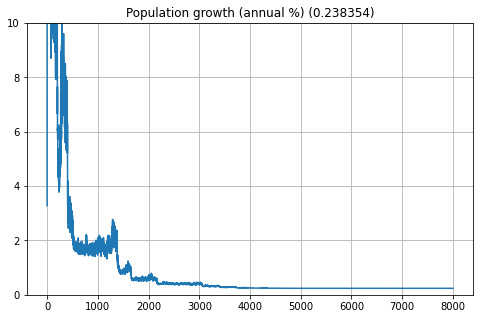

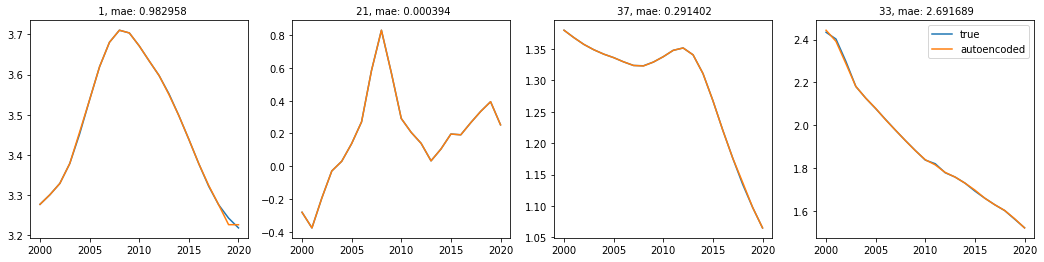

Population in the largest city (% of urban population)
3/3 [==============================] - 0s 5ms/step - loss: 3.1115
Loss: 1.066021. Before fine-tuning: 3.111497


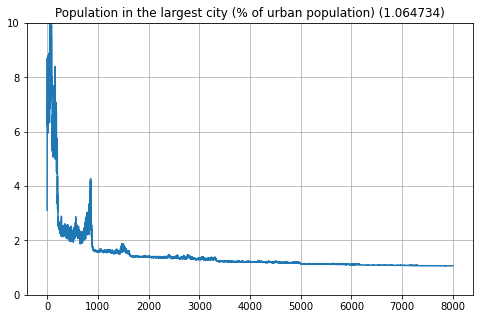

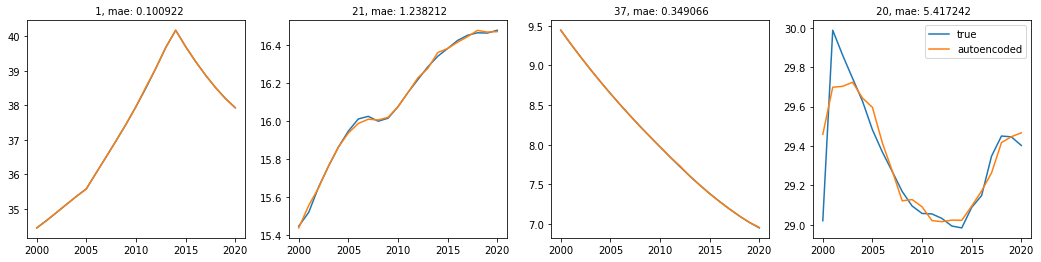

Total natural resources rents (% of GDP)
3/3 [==============================] - 0s 4ms/step - loss: 2.0600
Loss: 0.035776. Before fine-tuning: 2.060032


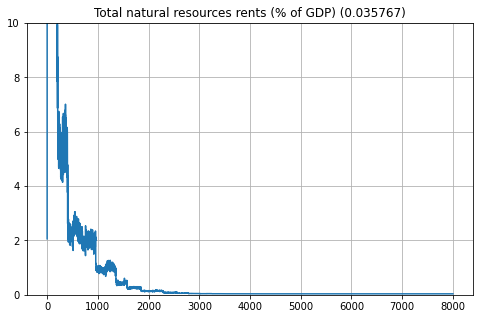

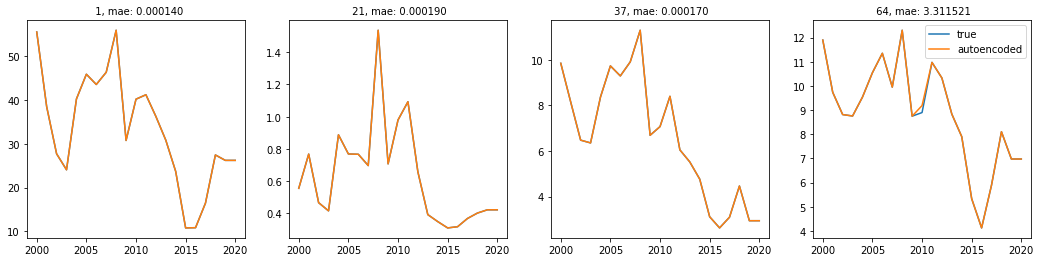

Unemployment, total (% of total labor force) (modeled ILO estimate)
3/3 [==============================] - 0s 3ms/step - loss: 4.4605
Loss: 0.187937. Before fine-tuning: 4.460461


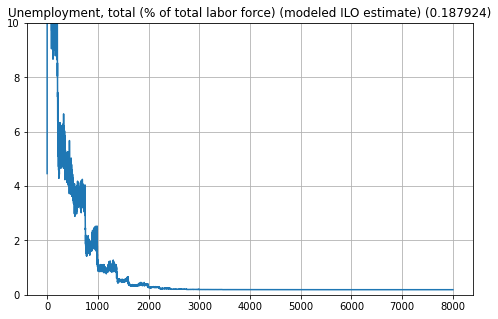

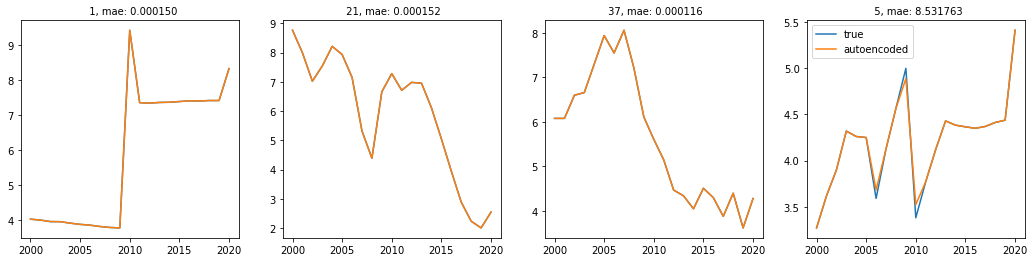

In [29]:
eval_features(N_BOTTLENECK, autoencoder_all, ymax=10, show_lr=False)